DONE - UPDATED 29 AUG 25

# 03_NB25 Clustering and Evaluation

***************

In [1]:
import pandas as pd
import os
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML
import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from matplotlib.colors import to_rgba

2025-09-07 20:28:01.439204: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-07 20:28:01.463206: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-07 20:28:01.463223: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-07 20:28:01.464061: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-07 20:28:01.468229: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# read in datasets 
nepalbirds2021_sample3_even = pd.read_csv("nepalbirds2021_sample3_even.csv")

## **1 - Dimensionality Reduction with UMAP**

**Adjust dataframe to numeric only columns for UMAP**

In [3]:
# limit features to only numeric columns
# NB the index on the left column can be used to map UMAP vectors back to their original path references
nepalbirds2021numeric_sample3_even = nepalbirds2021_sample3_even.drop(columns=['path','start_time','end_time','year','recorded_on','site','regime','min','max'])

In [4]:
nepalbirds2021numeric_sample3_even.head()

BirdNET_0  BirdNET_1  BirdNET_2  BirdNET_3  BirdNET_4  BirdNET_5  \
0   0.000000   0.059239   0.135251   0.636054   0.187086   0.430800   
1   0.234722   0.181848   0.092171   0.000000   1.094340   0.357427   
2   0.000000   0.048070   0.391850   0.187720   0.947669   0.560019   
3   0.000000   0.000033   0.184745   0.189055   0.374051   0.197123   
4   0.000000   0.000000   0.064940   0.224675   0.378810   0.559486   

   BirdNET_6  BirdNET_7  BirdNET_8  BirdNET_9  ...  BirdNET_1014  \
0   0.043622   0.429916   0.068448   0.666299  ...      0.271018   
1   0.529389   0.609460   0.000000   0.145642  ...      0.791693   
2   0.215717   0.190493   0.000000   0.340668  ...      0.018157   
3   0.330500   0.605835   0.000000   0.642164  ...      0.067500   
4   0.729803   0.000000   0.000000   0.516875  ...      0.000000   

   BirdNET_1015  BirdNET_1016  BirdNET_1017  BirdNET_1018  BirdNET_1019  \
0      0.460014      0.000000      0.658263      0.059256      0.352490   
1      0.158585      0.009818      0.172228      0.000000      0.271448   
2      0.227593      0.000000      0.381983      0.000000      0.290600   
3      0.035303      0.000000      0.361434      0.010866      0.113753   
4      0.000675      0.075799      0.000000      0.093989      0.290025   

   BirdNET_1020  BirdNET_1021  BirdNET_1022  BirdNET_1023  
0      0.000000      0.384284      0.032929      0.218379  
1      0.077424      0.000000      0.000000      0.419035  
2      0.246446      0.152236      0.000000      0.374425  
3      0.179495      0.000000      0.000000      0.626005  
4      0.142569      0.015914      0.021414      0.274457  

[5 rows x 1024 columns]

**Reduce to 2D with UMAP using Morales hyperparameters**

In [5]:
# apply UMAP to stratified sample features to reduce to 2-D (PARAMETER TEST 2)
NB25_SS3_umap2 = umap.UMAP(random_state=42, 
                  n_neighbors=20, 
                  n_components=2, 
                  min_dist=0.5,
                  local_connectivity=1,
                  metric='cosine').fit_transform(nepalbirds2021numeric_sample3_even)

/home/jupyter-tommills/.conda/envs/nepalbirds25/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


**Reduce to n-D with UMAP**

_The following three code blocks can be varied across n_components = 2, 16, 32, 64, 128 to give the differeing UMAP reduced diumension for section 4 to run HDBSCAN upon_

In [6]:
# set chosen dimensionality
dim = 32

In [7]:
# apply UMAP across higher dimensions (32)
NB25_SS3_umap32 = umap.UMAP(random_state=42,
    n_neighbors=20,
    n_components=dim,
    min_dist=0.5,
    local_connectivity=1,
    metric='cosine'
).fit_transform(nepalbirds2021numeric_sample3_even)

/home/jupyter-tommills/.conda/envs/nepalbirds25/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [8]:
df = pd.DataFrame(NB25_SS3_umap32)
df.head()

0         1         2         3         4         5         6   \
0  8.528954  4.672147  5.560839  5.202091  4.451119  4.852594  5.053844   
1  8.574377  4.512143  5.507194  5.253839  4.363475  4.842214  5.217072   
2  8.478310  4.713777  5.565503  5.143100  4.469778  4.890123  4.980491   
3  8.570865  4.523113  5.513863  5.247424  4.371691  4.842919  5.203651   
4  8.547605  4.567090  5.541119  5.209796  4.409940  4.854990  5.145920   

         7         8         9   ...        22        23        24        25  \
0  4.871370  4.975055  4.815069  ...  4.629839  5.774663  4.238729  3.826585   
1  4.853089  4.980687  4.928462  ...  4.643407  5.906874  4.085463  3.659003   
2  4.858479  4.981675  4.681880  ...  4.624390  5.756020  4.158285  3.862871   
3  4.853333  4.979516  4.915382  ...  4.641274  5.901865  4.090616  3.667987   
4  4.849535  4.977002  4.827604  ...  4.631712  5.891166  4.098472  3.713097   

         26        27        28        29        30        31  
0  6.277910  5.238279  5.498672  3.345690  5.318153  4.487981  
1  6.293163  5.531730  5.684265  3.060395  5.430024  4.011781  
2  6.277625  5.241796  5.514394  3.326911  5.334233  4.582539  
3  6.283457  5.511728  5.674555  3.074881  5.423345  4.049386  
4  6.291550  5.405039  5.659057  3.137125  5.404191  4.226063  

[5 rows x 32 columns]

## **2 - Clustering with HDBSCAN**

_The following three sections (4.1-4.3) can be varied across min_cluster_size = 5,20,50,100,150 to give the various silhouette scores and cluster sizes for the evaluation_

### **2.1 - Cluster and plot**

**Cluster 32-dimensional feature space with HDBSCAN**

In [9]:
# clustering 32D UMAP with HDBSCAN (note we need to generate the miniomum spanning tree for later relative validity check)
hdbscan_clusters_umap32 = hdbscan.HDBSCAN(min_cluster_size=50, gen_min_span_tree=True)
hdbscan_labels_umap32 = hdbscan_clusters_umap32.fit_predict(NB25_SS3_umap32)

/home/jupyter-tommills/.conda/envs/nepalbirds25/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jupyter-tommills/.conda/envs/nepalbirds25/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


**Plot 32-dimensional feature space with HDBSCAN on 2D UMAP**

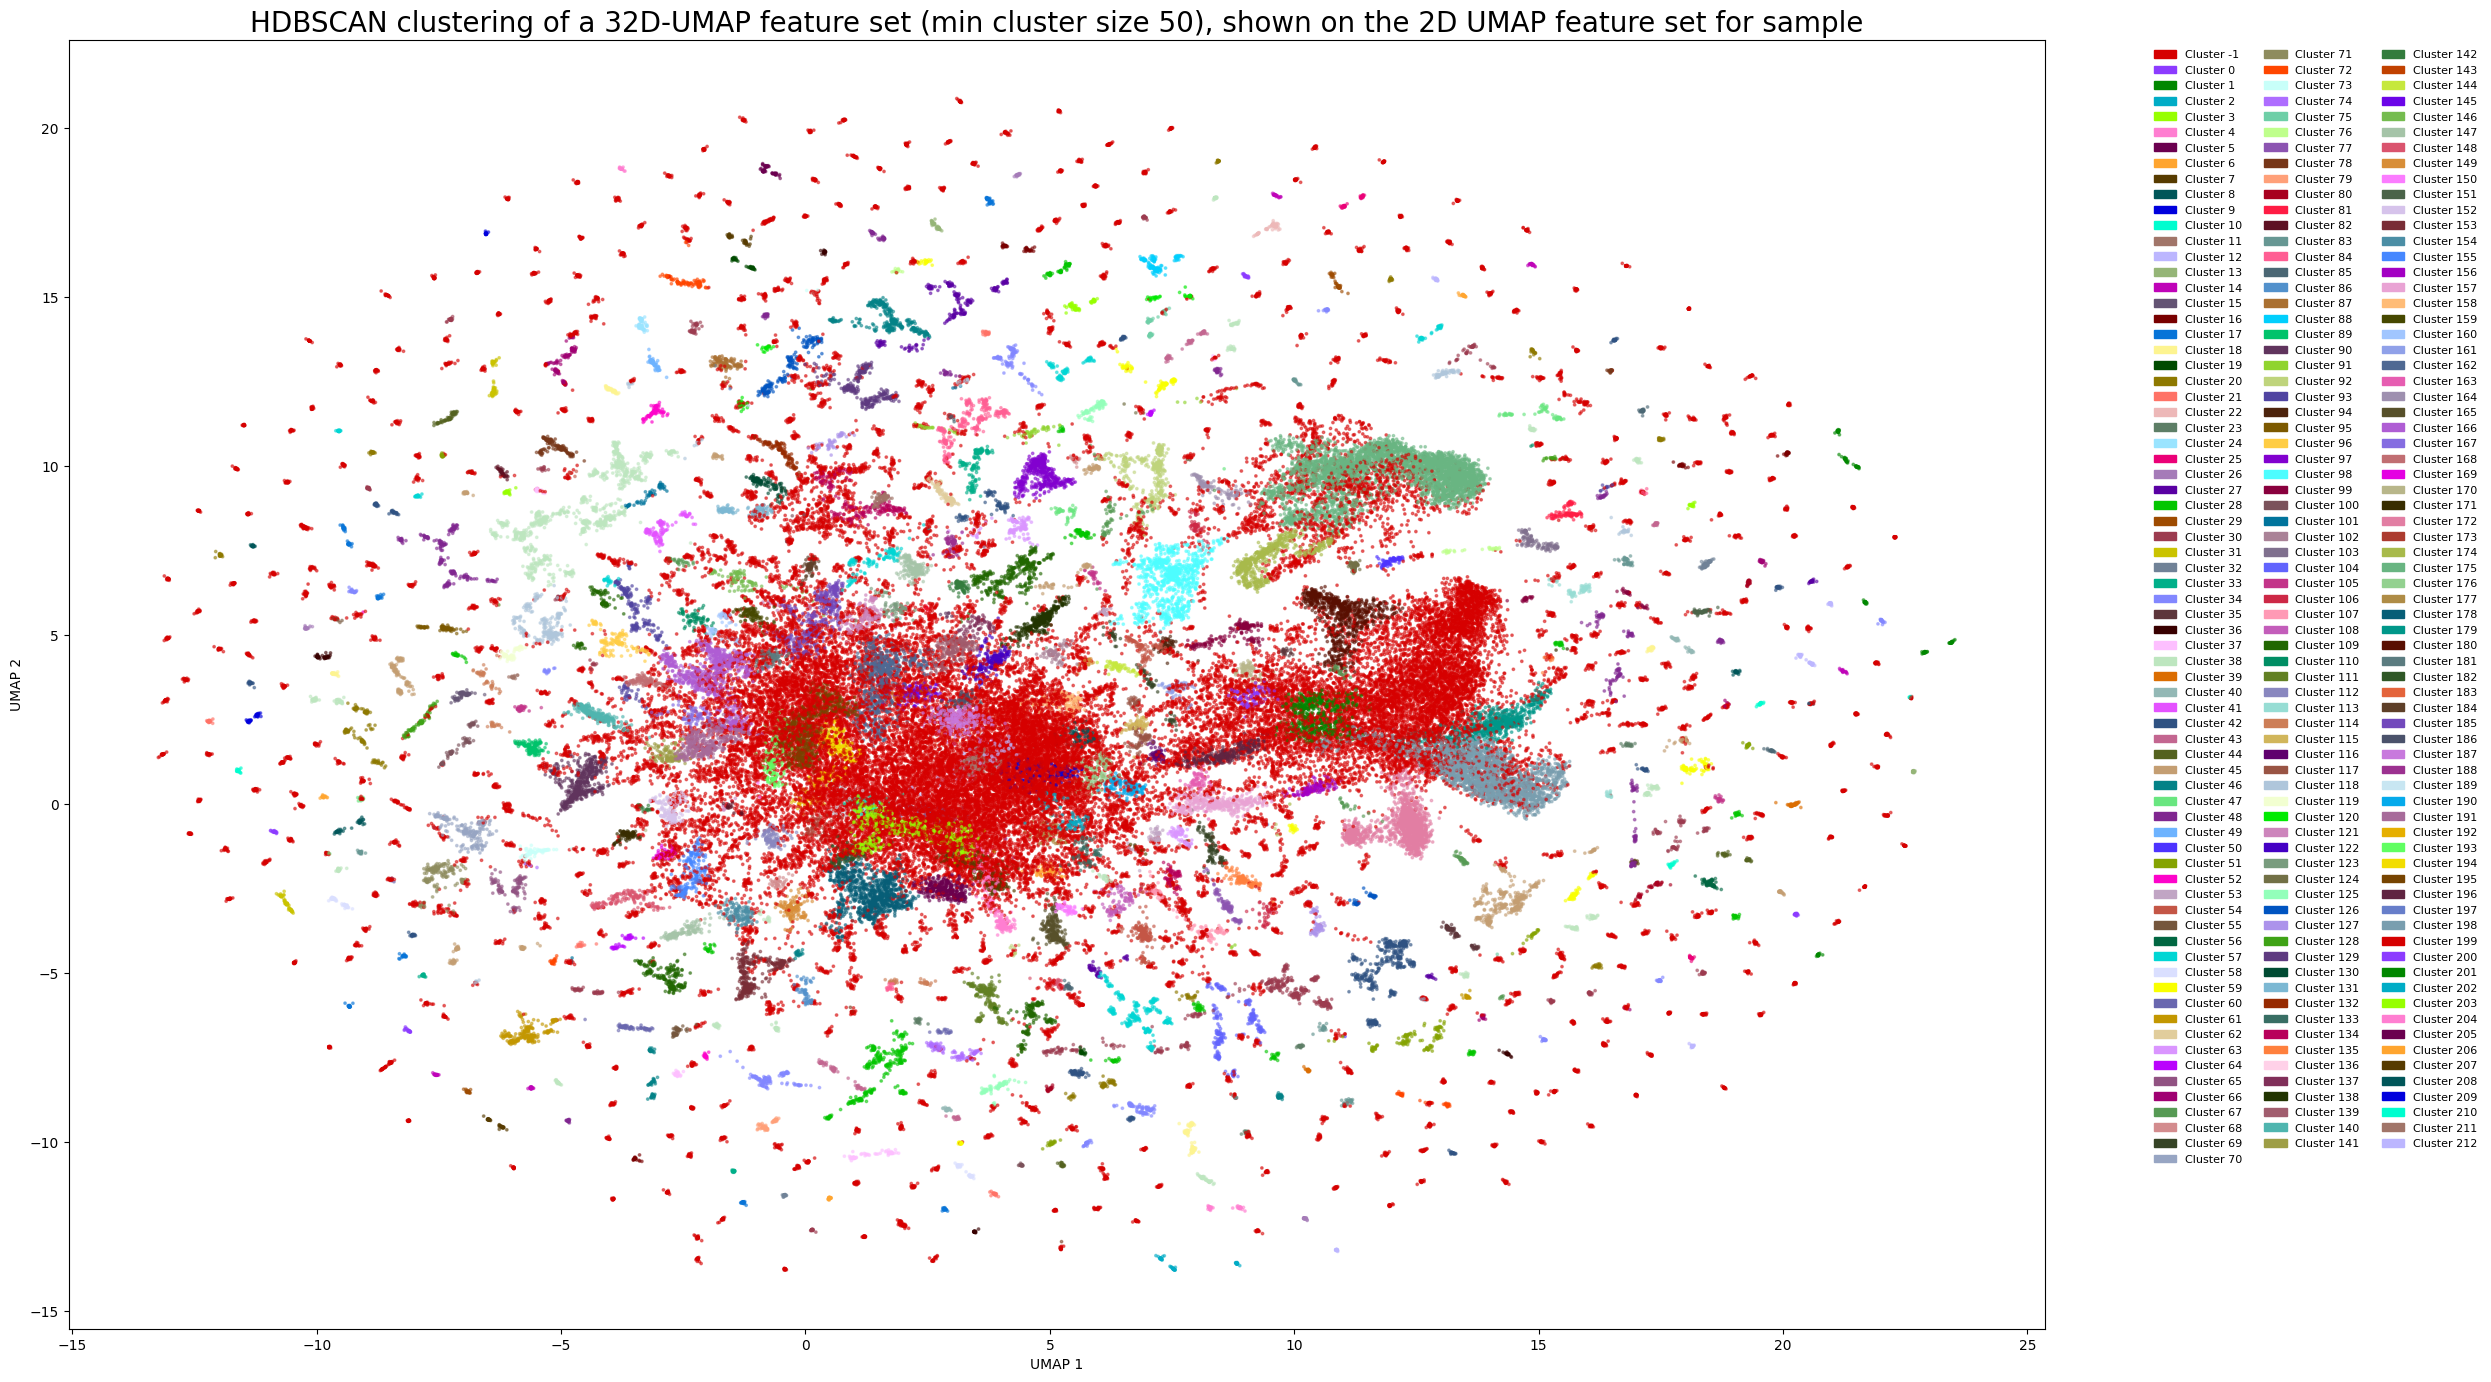

In [10]:
import matplotlib.patches as mpatches
import colorcet as cc

# set colour coding
colors = cc.glasbey[:200]

# plot graph
plt.figure(figsize=(25, 14))
plt.title('HDBSCAN clustering of a 32D-UMAP feature set (min cluster size 50), shown on the 2D UMAP feature set for sample', fontsize=20)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")

# assign color per cluster
cluster_ids = np.unique(hdbscan_labels_umap32)
cluster_to_color = {cid: colors[i % len(colors)] for i, cid in enumerate(cluster_ids)}
cluster_colors = [cluster_to_color[cid] for cid in hdbscan_labels_umap32]

# Plot using first two dimensions of 32D UMAP (or replace with true 2D UMAP if available)
plt.scatter(
    NB25_SS3_umap2[:, 0],
    NB25_SS3_umap2[:, 1],
    c=cluster_colors,
    s=3,
    alpha=0.5
)

# Legend
legend_patches = [
    mpatches.Patch(color=cluster_to_color[cid], label=f'Cluster {cid}')
    for cid in cluster_ids[:400]
]
plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8, ncol=3, frameon=False)
plt.tight_layout()
plt.show()

### **2.2 - Remove the HDBSCAN 'noise' cluster**

_**Plot the 2D UMAP visualisation of 32-D HDBSCAN without noise**_

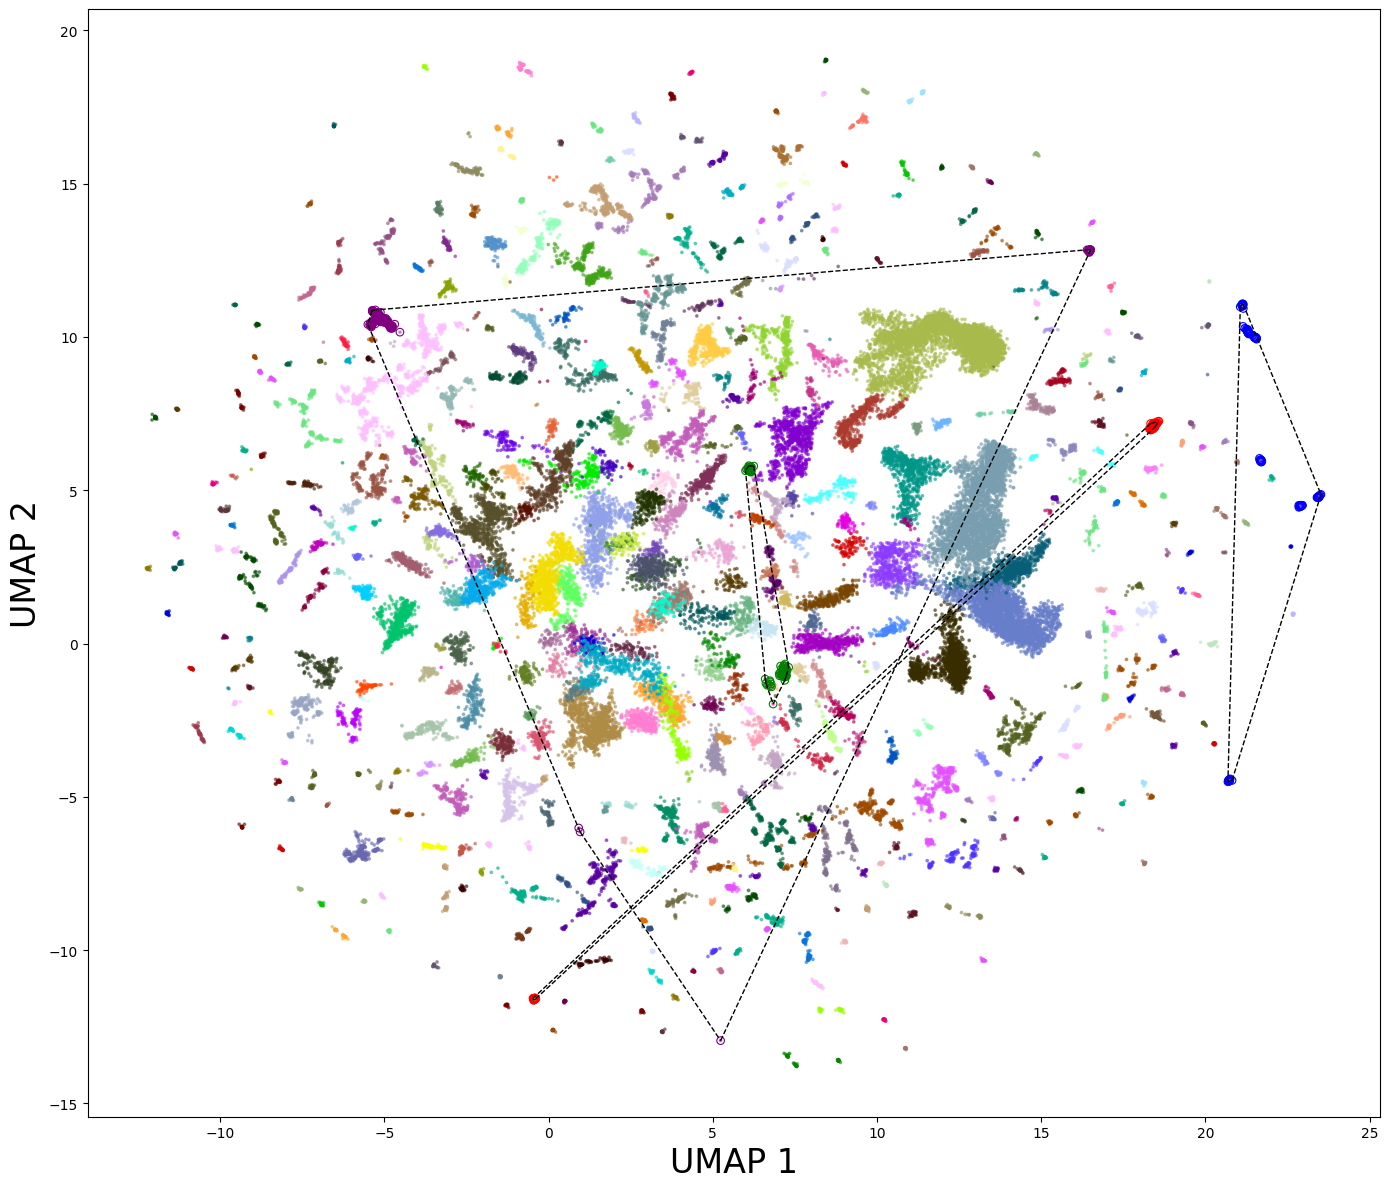

In [11]:
# set colour coding
colors = cc.glasbey[:200]

# filter out noise labels (-1)
mask_non_noise = hdbscan_labels_umap32 != -1
filtered_umap2 = NB25_SS3_umap2[mask_non_noise]
filtered_labels = hdbscan_labels_umap32[mask_non_noise]

# set colour coding
colors = cc.glasbey[:200]

# assign colors to clusters
cluster_ids = np.unique(filtered_labels)
cluster_to_color = {cid: colors[i % len(colors)] for i, cid in enumerate(cluster_ids)}
cluster_colors = [cluster_to_color[cid] for cid in filtered_labels]

# plot graph
plt.figure(figsize=(14, 12))
# plt.title('HDBSCAN clustering of a 32D-UMAP feature set (min clustersize 50), shown on the 2D UMAP feature set for the stratified sample', fontsize=20)
plt.xlabel("UMAP 1", fontsize = 24)
plt.ylabel("UMAP 2", fontsize = 24)

plt.scatter(
    filtered_umap2[:, 0],
    filtered_umap2[:, 1],
    c=cluster_colors,
    s=3,
    alpha=0.5)

# NB. the following (optional) block is to label as specific cluster by for the figure showing location of spectrograms
# it does so for the r randomly chosen clusters for the spectrogram visualisation fiure: 32, 1, 78, 53
# define cluster sample
clu_sample = [32, 1, 78, 53]
clu_colors = ['red', 'blue', 'purple', 'green']

for clu_id, edge_color in zip(clu_sample, clu_colors):
    mask = filtered_labels == clu_id
    points = filtered_umap2[mask]
    plt.scatter(
        points[:, 0],
        points[:, 1],
        edgecolors=edge_color,
        facecolors='none',
        s=30,
        linewidths=0.8)
    
# NB2. this extra part adds the black dotted line around the cluster 
    from scipy.spatial import ConvexHull
    hull = ConvexHull(points)
    for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1], 'k--', linewidth=1)

# create legend
#legend_patches = [
#    mpatches.Patch(color=cluster_to_color[cid], label=f'Cluster {cid}')
#    for cid in cluster_ids[:300]]
#plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8, ncol=3, frameon=False)

plt.tight_layout()
plt.savefig("umap32_hdbscan50_clusters_plus_sample.png", dpi=600, bbox_inches='tight')
plt.show()

In [12]:
# count number of noise embeddings 
print((hdbscan_labels_umap32 == -1).sum())

47278


In [13]:
# count all embeddings
nepalbirds2021_sample3_even.shape[0]

96807

### **2.3 - Evaluation of HDBSCAN hyperparameter choice**

_**Cluster count**_

In [14]:
#counts the number of clusters, excluding the noise points classified as '-1'
num_clusters_umap32 = len(np.unique(hdbscan_labels_umap32[hdbscan_labels_umap32 != -1]))
print(f"Number of clusters (excluding noise): {num_clusters_umap32}")

Number of clusters (excluding noise): 213


_**HDBSCAN relative validity**_

In [15]:
hdb_rv = hdbscan_clusters_umap32.relative_validity_
print("Relative validity:", hdb_rv)

Relative validity: 0.2288666138153243


**Silhouette Score**

In [16]:
# calculate silhouette score for 32D UMAP - HBDSCAN

from sklearn.metrics import silhouette_score

# calc silhouette score, excluding noise points '-1'
mask = hdbscan_labels_umap32 != -1
if mask.sum() > 1:  # Need at least 2 non-noise points
    silhouette_avg = silhouette_score(
        NB25_SS3_umap32 [mask], 
        hdbscan_labels_umap32[mask])
    print(f"Silhouette Score: {silhouette_avg:.3f}")
else:
    print("n/a")

Silhouette Score: 0.544


## **3 - Map cluster labels to main sample dataframe**

_**Create a dataframe that maps the cluster numbers to the original dataframe**_

In [17]:
# ensure indexes are aligned - should be fine as index was not reset
assert NB25_SS3_umap2.shape[0] == len(hdbscan_labels_umap32)

In [18]:
# add cluster labels in a series matched by the index
cluster_labels = pd.Series(
    hdbscan_labels_umap32, 
    name='cluster', 
    index=nepalbirds2021_sample3_even.index)

# create new df with cluster column added
nepalbirds2021_sample3_even_clustered = nepalbirds2021_sample3_even.assign(
    cluster=cluster_labels)

In [19]:
nepalbirds2021_sample3_even_clustered.shape

(96807, 1034)

_**Add column of if any detections or not**_

In [20]:
# read in detections
nepalbirds_detections = pd.read_parquet("data/nepal/birdnet_detections/nepalbirds_detections_merged.parquet")

In [21]:
# drop existing 'detections_count' column if it exists
nepalbirds2021_sample3_even_clustered = nepalbirds2021_sample3_even_clustered.drop(
    columns=['detections_count','detections_count_y','detections_count_x'], errors='ignore')

# filter confident detections (score > 0.5)
confident_detections = nepalbirds_detections[
    pd.to_numeric(nepalbirds_detections['score'], errors='coerce') > 0.5]

# count detections per audio segment
detections_count = (
    confident_detections
    .groupby(['path', 'start_time', 'end_time'])
    .size()
    .reset_index(name='detections_count'))

# merge count into main dataframe
nepalbirds2021_sample3_even_clustered = nepalbirds2021_sample3_even_clustered.merge(
    detections_count,
    on=['path', 'start_time', 'end_time'],
    how='left')

# fill missing values with 0
nepalbirds2021_sample3_even_clustered['detections_count'] = (
    nepalbirds2021_sample3_even_clustered['detections_count'].fillna(0).astype(int))

In [22]:
# Export to CSV
nepalbirds2021_sample3_even_clustered.to_csv("nepalbirds2021_sample3_even_clustered.csv", index=False)

In [23]:
# how many in sample have detections?
print((nepalbirds2021_sample3_even_clustered["detections_count"] > 0).sum())

10607


In [24]:
# check how many embeddings in full sample
print(len(nepalbirds2021_sample3_even_clustered))

96807


## **4 - Create Sample for Validation**

_**Select random sample of 20 clusters x 30 features to validate**_

In [25]:
# select random sample of 20 clusters excluding noise (-1) and 30 files from each (15 with detections; 15 without)

# Set random seed for reproducibility
np.random.seed(42)

# Filter out noise
valid_df = nepalbirds2021_sample3_even_clustered[nepalbirds2021_sample3_even_clustered['cluster'] != -1]

# Count detections and non-detections per cluster
cluster_counts = valid_df.groupby('cluster')['detections_count'].agg([
    ('with_detections', lambda x: (x > 0).sum()),
    ('without_detections', lambda x: (x == 0).sum())
])

# Keep clusters with at least 15 of each
eligible_clusters = cluster_counts[
    (cluster_counts['with_detections'] >= 15) &
    (cluster_counts['without_detections'] >= 15)
].index.tolist()

# Randomly select 20 clusters from eligible ones
selected_clusters = np.random.choice(eligible_clusters, size=20, replace=False)

# Filter to selected clusters
cluster_subset_df = valid_df[valid_df['cluster'].isin(selected_clusters)]

# Sample 15 with detections and 15 without per cluster
def balanced_cluster_sample(group):
    with_detections = group[group['detections_count'] > 0]
    without_detections = group[group['detections_count'] == 0]

    sample_with = with_detections.sample(n=15, random_state=42)
    sample_without = without_detections.sample(n=15, random_state=42)

    return pd.concat([sample_with, sample_without])

# Apply sampling
sampled_clusters_df = (
    cluster_subset_df.groupby('cluster', group_keys=False)
    .apply(balanced_cluster_sample)
    .reset_index(drop=True)
)

# Select desired columns
cluster_output_df = sampled_clusters_df[['path', 'cluster', 'start_time', 'end_time', 'detections_count']]

# Display as scrollable HTML table
cluster_html_table = cluster_output_df.to_html(index=False)
cluster_scrollable_html = f"""
<div style="height:400px; overflow:auto; border:1px solid #ccc; padding:10px">
<h3>Sampled Files from 20 Clusters (≥15 detections & ≥15 non-detections)</h3>
{cluster_html_table}
</div>
"""

display(HTML(cluster_scrollable_html))

/tmp/ipykernel_3995826/3144877376.py:40: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(balanced_cluster_sample)


In [26]:
# quick check of how many features with no detections
(sampled_clusters_df['detections_count'] == 0).sum()

300

In [27]:
# 7 - summary table of detection counts per cluster
summary_table = (
    sampled_clusters_df
    .assign(has_detection = sampled_clusters_df['detections_count'] > 0)
    .groupby(['cluster', 'has_detection'])
    .size()
    .unstack(fill_value=0)
    .rename(columns={False: 'no_detections', True: 'has_detections'})
    .reset_index()
)

# display as scrollable HTML table
summary_html = summary_table.to_html(index=False)
scrollable_summary = f"""
<div style="height:300px; overflow:auto; border:1px solid #ccc; padding:10px">
<h3>Detection Summary per Cluster</h3>
{summary_html}
</div>
"""

display(HTML(scrollable_summary))

In [28]:
cluster_output_df.to_csv('nepalbirds2_clusters_sample3.csv', index=False)
print("done")

done


_**Select random sample of noise x 100 features to validate**_

In [29]:
# filter to noise cluster (-1)
noise_cluster_df = nepalbirds2021_sample3_even_clustered[
    nepalbirds2021_sample3_even_clustered['cluster'] == -1]

# split by detection presence
noise_with_detections = noise_cluster_df[noise_cluster_df['detections_count'] > 0]
noise_without_detections = noise_cluster_df[noise_cluster_df['detections_count'] == 0]

# sample 50 from each group
np.random.seed(42)
sample_with = noise_with_detections.sample(n=min(50, len(noise_with_detections)), random_state=42)
sample_without = noise_without_detections.sample(n=min(50, len(noise_without_detections)), random_state=42)

# combine samples
balanced_noise_df = pd.concat([sample_with, sample_without], ignore_index=True)

# select desired columns
noise_output_df = balanced_noise_df[['path', 'cluster', 'start_time', 'end_time', 'detections_count']]

# display as scrollable table
noise_html_table = noise_output_df.to_html(index=False)
noise_scrollable_html = f"""
<div style="height:400px; overflow:auto; border:1px solid #ccc; padding:10px">
<h3>Balanced Sample from Noise Cluster (-1): 50 with detections, 50 without</h3>
{noise_html_table}
</div>
"""

display(HTML(noise_scrollable_html))

In [30]:
# Step 7 - export to CSV
noise_output_df.to_csv('nepalbirds2_clusternoise_sample3.csv', index=False)
print("done")

done


## **5a - Test for biases in the Clusters by Location and Habitat (Main HDBSCAN)**

_**Sites as labels on the 2D UMAP**_

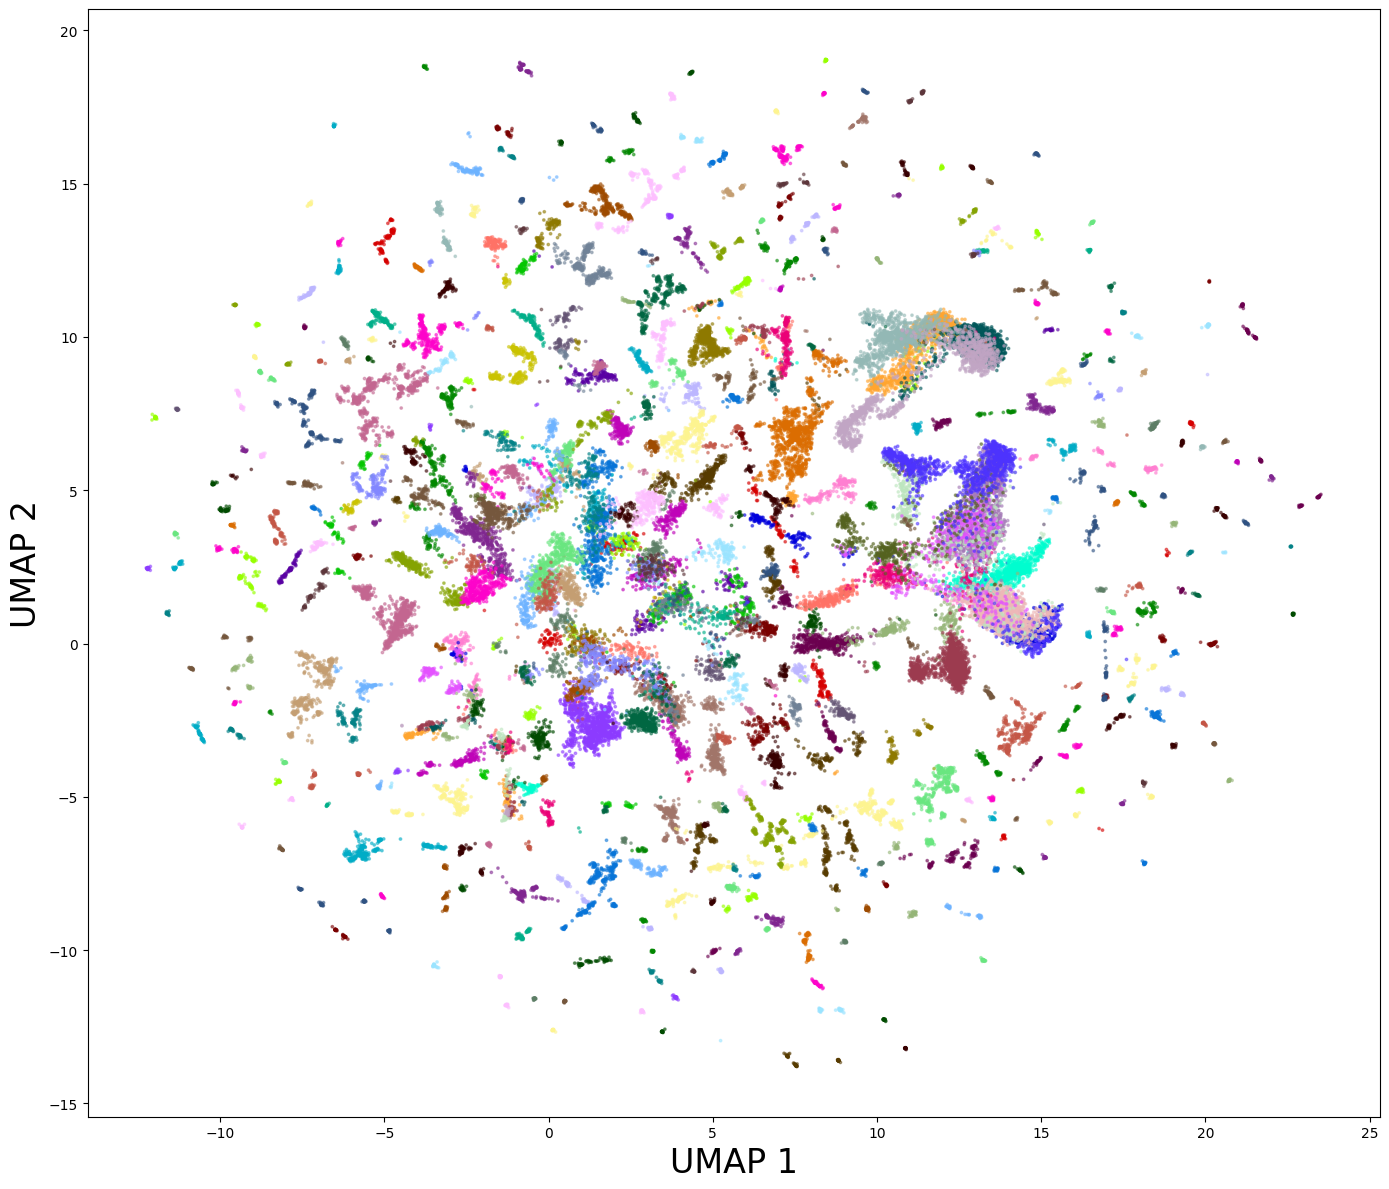

In [31]:
# adapt the code for HDBSCAN visualisation to label the different sites

# set colour coding
colors = cc.glasbey[:200]

# filter out noise labels (-1)
mask_non_noise = hdbscan_labels_umap32 != -1
filtered_umap2 = NB25_SS3_umap2[mask_non_noise]
filtered_labels = hdbscan_labels_umap32[mask_non_noise]
sites_filtered = nepalbirds2021_sample3_even["site"].iloc[mask_non_noise]

# assign colors to clusters
cluster_ids = np.unique(sites_filtered)
cluster_to_color = {cid: colors[i % len(colors)] for i, cid in enumerate(cluster_ids)}
cluster_colors = [cluster_to_color[cid] for cid in sites_filtered]

# plot graph
plt.figure(figsize=(14, 12))
plt.title("", fontsize=20)
plt.xlabel("UMAP 1", fontsize=24)
plt.ylabel("UMAP 2", fontsize=24)

plt.scatter(
    filtered_umap2[:, 0],
    filtered_umap2[:, 1],
    c=cluster_colors,
    s=3,
    alpha=0.5)
plt.tight_layout()
plt.savefig("hdbscan32_sites_coloured.png", dpi=300, bbox_inches="tight")
plt.show()

In [32]:
# table showing % of rows/points in a cluster for hdbscan_labels_SS3umap32even2021 != -1 that are from each site

In [33]:

# build cluster-site df
df_cluster_site = pd.DataFrame({
    "cluster": filtered_labels,
    "site": sites_filtered
})

# count site occurrences per cluster
cluster_site_counts = df_cluster_site.groupby(["cluster", "site"]).size().unstack(fill_value=0)

# count total count per cluster
cluster_counts = cluster_site_counts.sum(axis=1)

# convert counts to %
cluster_site_percent = cluster_site_counts.div(cluster_counts, axis=0) * 100
cluster_site_percent = cluster_site_percent.round(1).sort_index(axis=1)

# add col for count
cluster_site_percent["count"] = cluster_counts

# identify dominant site and its percentage
site_percent_only = cluster_site_percent.drop(columns="count")
dominant_site = site_percent_only.idxmax(axis=1)
dominant_percent = site_percent_only.max(axis=1)

# build summary table
dominant_summary = pd.DataFrame({
    "Dominant Site": dominant_site,
    "Percentage": dominant_percent.round(1),
    "Count": cluster_site_percent["count"]})

# add unique label to combine later with other test cases
dominant_summary_case2 = dominant_summary.copy() 

# display scrollable table
scrollable_html = dominant_summary.style.set_table_attributes(
    'style="display:inline-block;overflow-x:auto;max-width:1000px;"'
).set_caption("Highest percentage contribution of a site per cluster")

display(HTML(scrollable_html.to_html()))

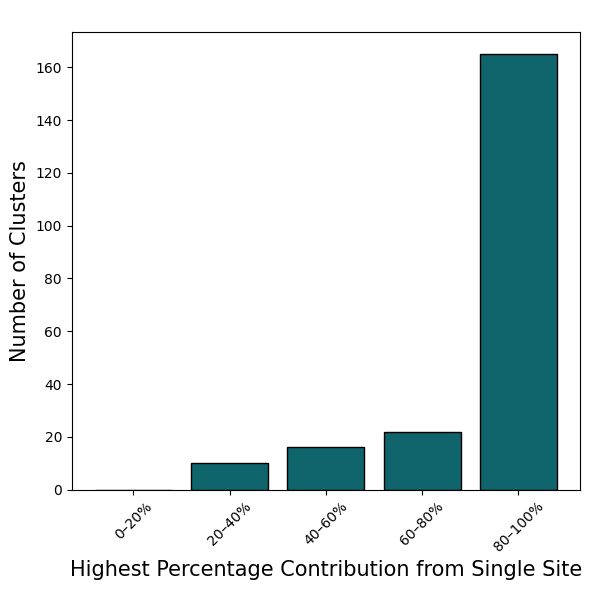

In [34]:
# plot histo of number of clusters per percentage band

# take percentage column from table
dominant_percentages = dominant_summary["Percentage"]

# set bins and structure of histo
bins = range(0, 120, 20)  # 0 to 100 in steps of 10
bin_labels = [f"{i}–{i+20}%" for i in bins[:-1]]
hist = pd.cut(dominant_percentages, bins=bins, labels=bin_labels, include_lowest=True)
bin_counts = hist.value_counts().sort_index()

# plot histo
plt.figure(figsize=(6, 6))
plt.bar(bin_counts.index, bin_counts.values, color="#10646b", edgecolor="black")
plt.xticks(rotation=45)
plt.xlabel("Highest Percentage Contribution from Single Site", fontsize=15)
plt.ylabel("Number of Clusters", fontsize=15)
plt.title("   ")
plt.tight_layout()
plt.show()

In [35]:
# calculate Adjusted Rand Index 

# ARI and AMI with noise excluded
ari = adjusted_rand_score(sites_filtered, filtered_labels)
ami = adjusted_mutual_info_score(sites_filtered, filtered_labels)

print("ARI:", ari)
print("AMI:", ami)

ARI excl. noise: 0.4530786927059335
AMI excl. noise: 0.776805202062125


In [36]:
import pandas as pd 
# convert histo data to table with percentage column
total_clusters = bin_counts.sum()
bin_table = pd.DataFrame({
    "Percentage Band": bin_counts.index,
    "Number of Clusters": bin_counts.values,
    "% of Clusters": (bin_counts.values / total_clusters * 100).round(1)
})
bin_table

Percentage Band  Number of Clusters  % of Clusters
0           0–20%                   0            0.0
1          20–40%                  10            4.7
2          40–60%                  16            7.5
3          60–80%                  22           10.3
4         80–100%                 165           77.5

_**Regions as labels on the 2D UMAP**_

## **5b - Test for biases in the Clusters by Location and Habitat (HDBSCAN-2D)**

In [74]:
# apply UMAP to stratified sample features to reduce to 2-D (PARAMETER TEST 2)
NB25_SS3_umap2eva = umap.UMAP(random_state=42, 
                  n_neighbors=40, 
                  n_components=2, 
                  min_dist=0.1,
                  local_connectivity=1,
                  metric='euclidean').fit_transform(nepalbirds2021numeric_sample3_even)

/home/jupyter-tommills/.conda/envs/nepalbirds25/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [75]:
# clustering 32D UMAP with HDBSCAN (note we need to generate the miniomum spanning tree for later relative validity check)
hdbscan_clusters_umap2eva = hdbscan.HDBSCAN(min_cluster_size=50, gen_min_span_tree=True)
hdbscan_labels_umap2eva = hdbscan_clusters_umap2eva.fit_predict(NB25_SS3_umap2eva)

/home/jupyter-tommills/.conda/envs/nepalbirds25/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jupyter-tommills/.conda/envs/nepalbirds25/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


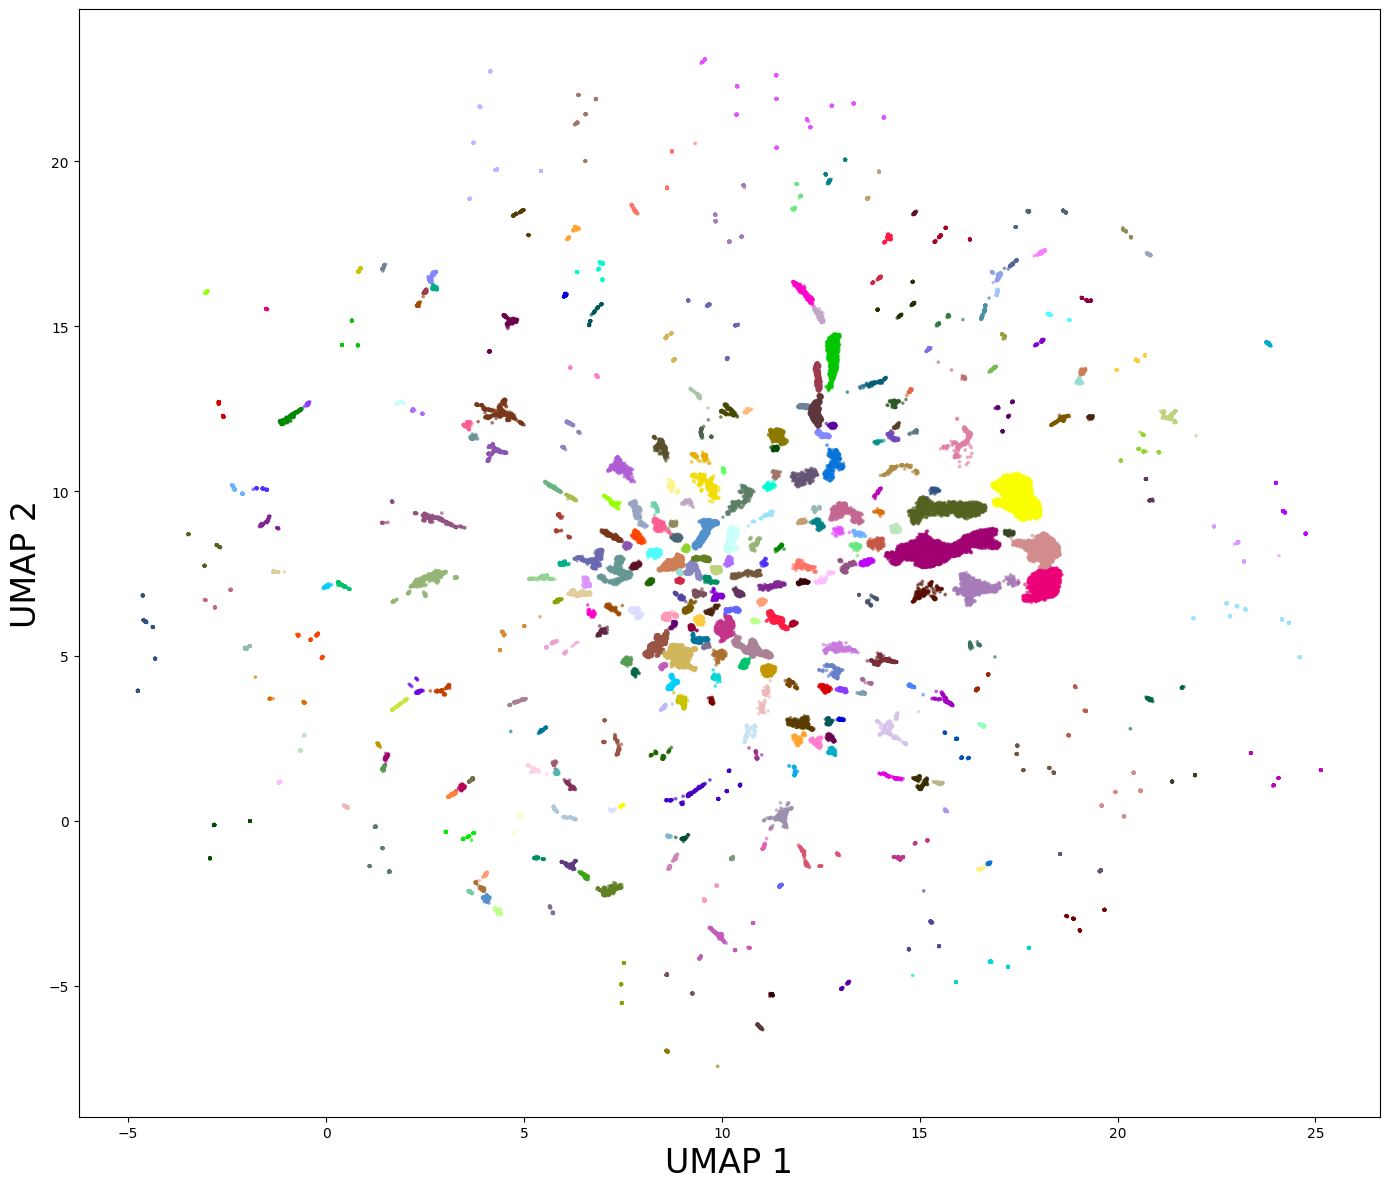

In [76]:
# plot hdbscan without noise

# set colour coding
colors = cc.glasbey[:200]

# filter out noise labels (-1)
mask_non_noise = hdbscan_labels_umap2eva != -1
filtered_umap2 = NB25_SS3_umap2eva[mask_non_noise]
filtered_labels = hdbscan_labels_umap2eva[mask_non_noise]

# set colour coding
colors = cc.glasbey[:200]

# assign colors to clusters
cluster_ids = np.unique(filtered_labels)
cluster_to_color = {cid: colors[i % len(colors)] for i, cid in enumerate(cluster_ids)}
cluster_colors = [cluster_to_color[cid] for cid in filtered_labels]

# plot graph
plt.figure(figsize=(14, 12))
# plt.title('HDBSCAN clustering of a 32D-UMAP feature set (min clustersize 50), shown on the 2D UMAP feature set for the stratified sample', fontsize=20)
plt.xlabel("UMAP 1", fontsize = 24)
plt.ylabel("UMAP 2", fontsize = 24)

plt.scatter(
    filtered_umap2[:, 0],
    filtered_umap2[:, 1],
    c=cluster_colors,
    s=3,
    alpha=0.5)

# create legend
#legend_patches = [
#    mpatches.Patch(color=cluster_to_color[cid], label=f'Cluster {cid}')
#    for cid in cluster_ids[:300]]
#plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8, ncol=3, frameon=False)

plt.tight_layout()
plt.savefig("umap2_hdbscan50_clusters.png", dpi=600, bbox_inches='tight')
plt.show()

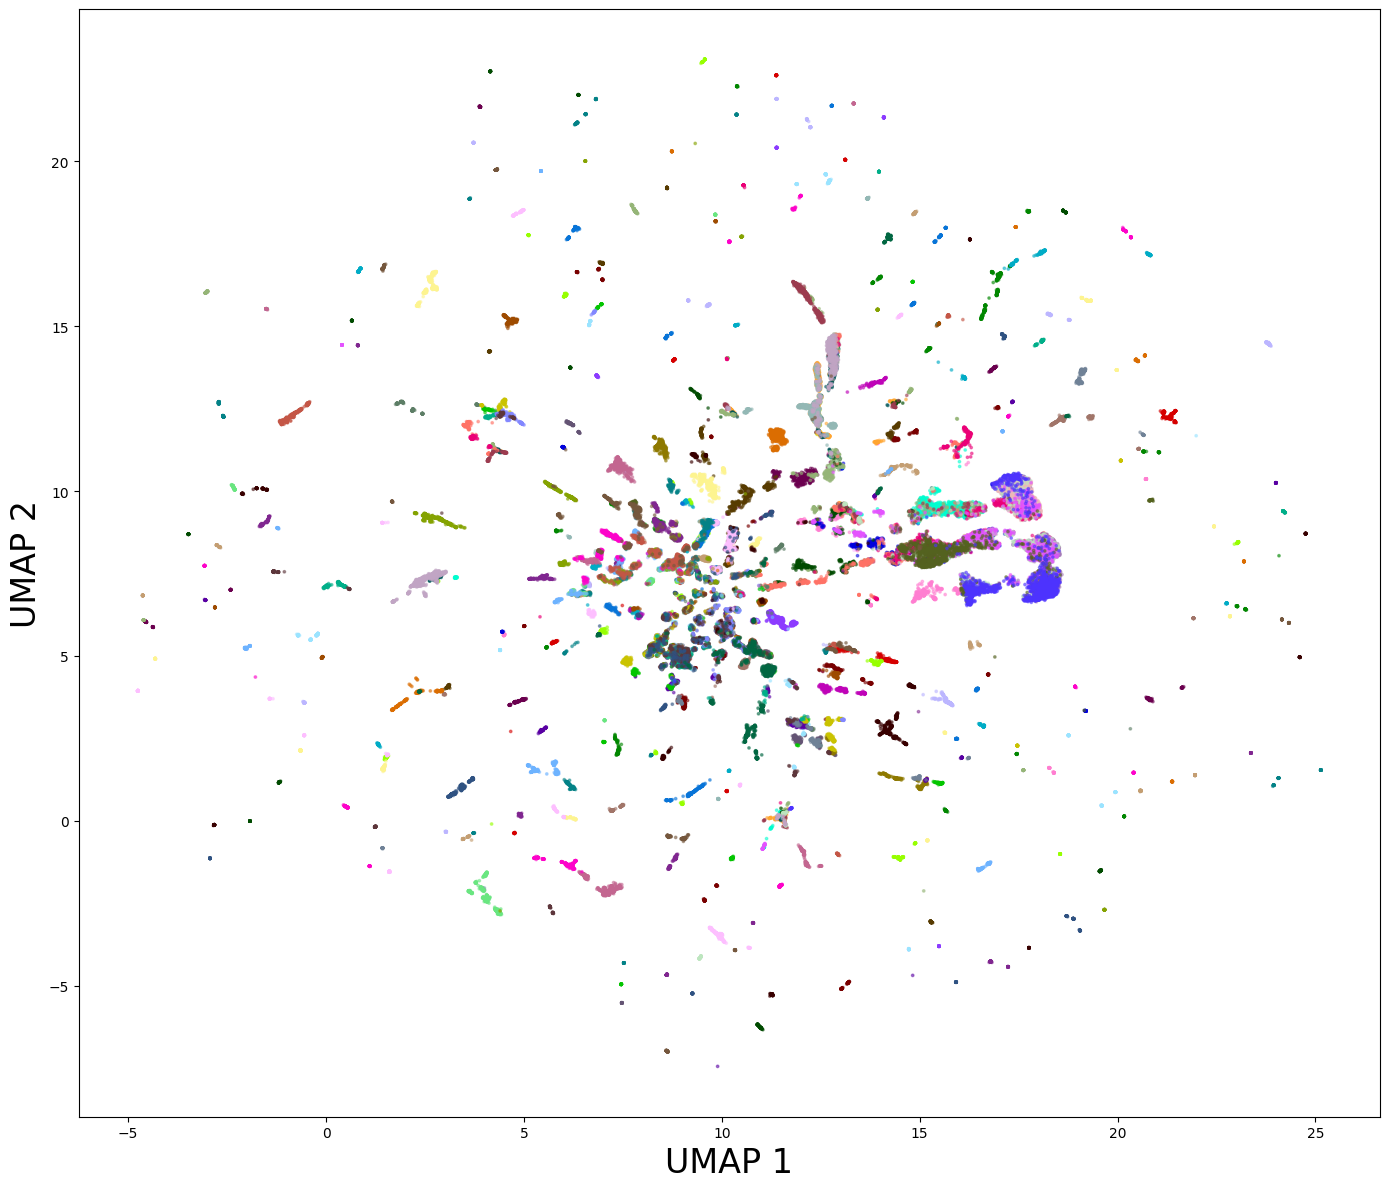

In [77]:
# adapt the code for HDBSCAN visualisation to label the different sites

# set colour coding
colors = cc.glasbey[:200]

# filter out noise labels (-1)
mask_non_noise = hdbscan_labels_umap2eva != -1
filtered_umap2 = NB25_SS3_umap2eva[mask_non_noise]
filtered_labels = hdbscan_labels_umap2eva[mask_non_noise]
sites_filtered = nepalbirds2021_sample3_even["site"].iloc[mask_non_noise]

# assign colors to clusters
cluster_ids = np.unique(sites_filtered)
cluster_to_color = {cid: colors[i % len(colors)] for i, cid in enumerate(cluster_ids)}
cluster_colors = [cluster_to_color[cid] for cid in sites_filtered]

# plot graph
plt.figure(figsize=(14, 12))
plt.title("", fontsize=20)
plt.xlabel("UMAP 1", fontsize=24)
plt.ylabel("UMAP 2", fontsize=24)

plt.scatter(
    filtered_umap2[:, 0],
    filtered_umap2[:, 1],
    c=cluster_colors,
    s=3,
    alpha=0.5)

# create legend
# legend_patches = [
#    mpatches.Patch(color=cluster_to_color[cid], label=f'Site: {cid}')
#    for cid in cluster_ids[:100]]
#
# plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=16, ncol=2, frameon=False)

plt.tight_layout()
plt.savefig("hdbscan2_sites_coloured.png", dpi=300, bbox_inches="tight")
plt.show()

In [78]:
# build cluster-site df
df_cluster_site = pd.DataFrame({
    "cluster": filtered_labels1,
    "site": sites_filtered1
})

# count site occurrences per cluster
cluster_site_counts = df_cluster_site.groupby(["cluster", "site"]).size().unstack(fill_value=0)

# count total count per cluster
cluster_counts = cluster_site_counts.sum(axis=1)

# convert counts to percentages
cluster_site_percent = cluster_site_counts.div(cluster_counts, axis=0) * 100
cluster_site_percent = cluster_site_percent.round(1).sort_index(axis=1)

# add count column
cluster_site_percent["count"] = cluster_counts

# identify dominant site and its percentage
site_percent_only = cluster_site_percent.drop(columns="count")
dominant_site = site_percent_only.idxmax(axis=1)
dominant_percent = site_percent_only.max(axis=1)

# build summary table
dominant_summary = pd.DataFrame({
    "Dominant Site": dominant_site,
    "Percentage": dominant_percent.round(1),
    "Count": cluster_site_percent["count"]})

# add label to combiine later with other test cases
dominant_summary_case1 = dominant_summary.copy() 

# display scrollable table
scrollable_html = dominant_summary.style.set_table_attributes(
    'style="display:inline-block;overflow-x:auto;max-width:1000px;"'
).set_caption("Highest percentage contribution of a site per cluster")

display(HTML(scrollable_html.to_html()))

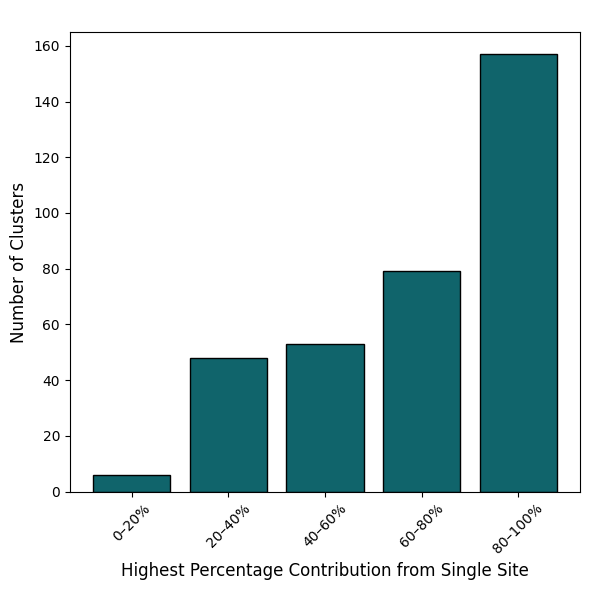

In [79]:
# plot histo of number of clusters per percentage band

# take percentage column from table
dominant_percentages = dominant_summary["Percentage"]

# set bins and structure of histo
bins = range(0, 120, 20)  # 0 to 100 in steps of 10
bin_labels = [f"{i}–{i+20}%" for i in bins[:-1]]
hist = pd.cut(dominant_percentages, bins=bins, labels=bin_labels, include_lowest=True)
bin_counts = hist.value_counts().sort_index()

# plot histo
plt.figure(figsize=(6, 6))
plt.bar(bin_counts.index, bin_counts.values, color="#10646b", edgecolor="black")
plt.xticks(rotation=45)
plt.xlabel("Highest Percentage Contribution from Single Site", fontsize=12)
plt.ylabel("Number of Clusters", fontsize=12)
plt.title("   ")
plt.tight_layout()
plt.show()

## **5c - Test for biases in the Clusters by Location and Habitat (k-means)**

In [80]:
# creates k-means clustering object with number of clusters chosen and reproducability
# carried out on the same 32d umap as the original hdbscan 
# with 'fit' finding the optimal cluster centres and 'predict' assigning each point to the nearest cluster
from sklearn import cluster
from sklearn.cluster import KMeans 
kmeans_labels = cluster.KMeans(n_clusters=200, random_state=42).fit_predict(NB25_SS3_umap32)

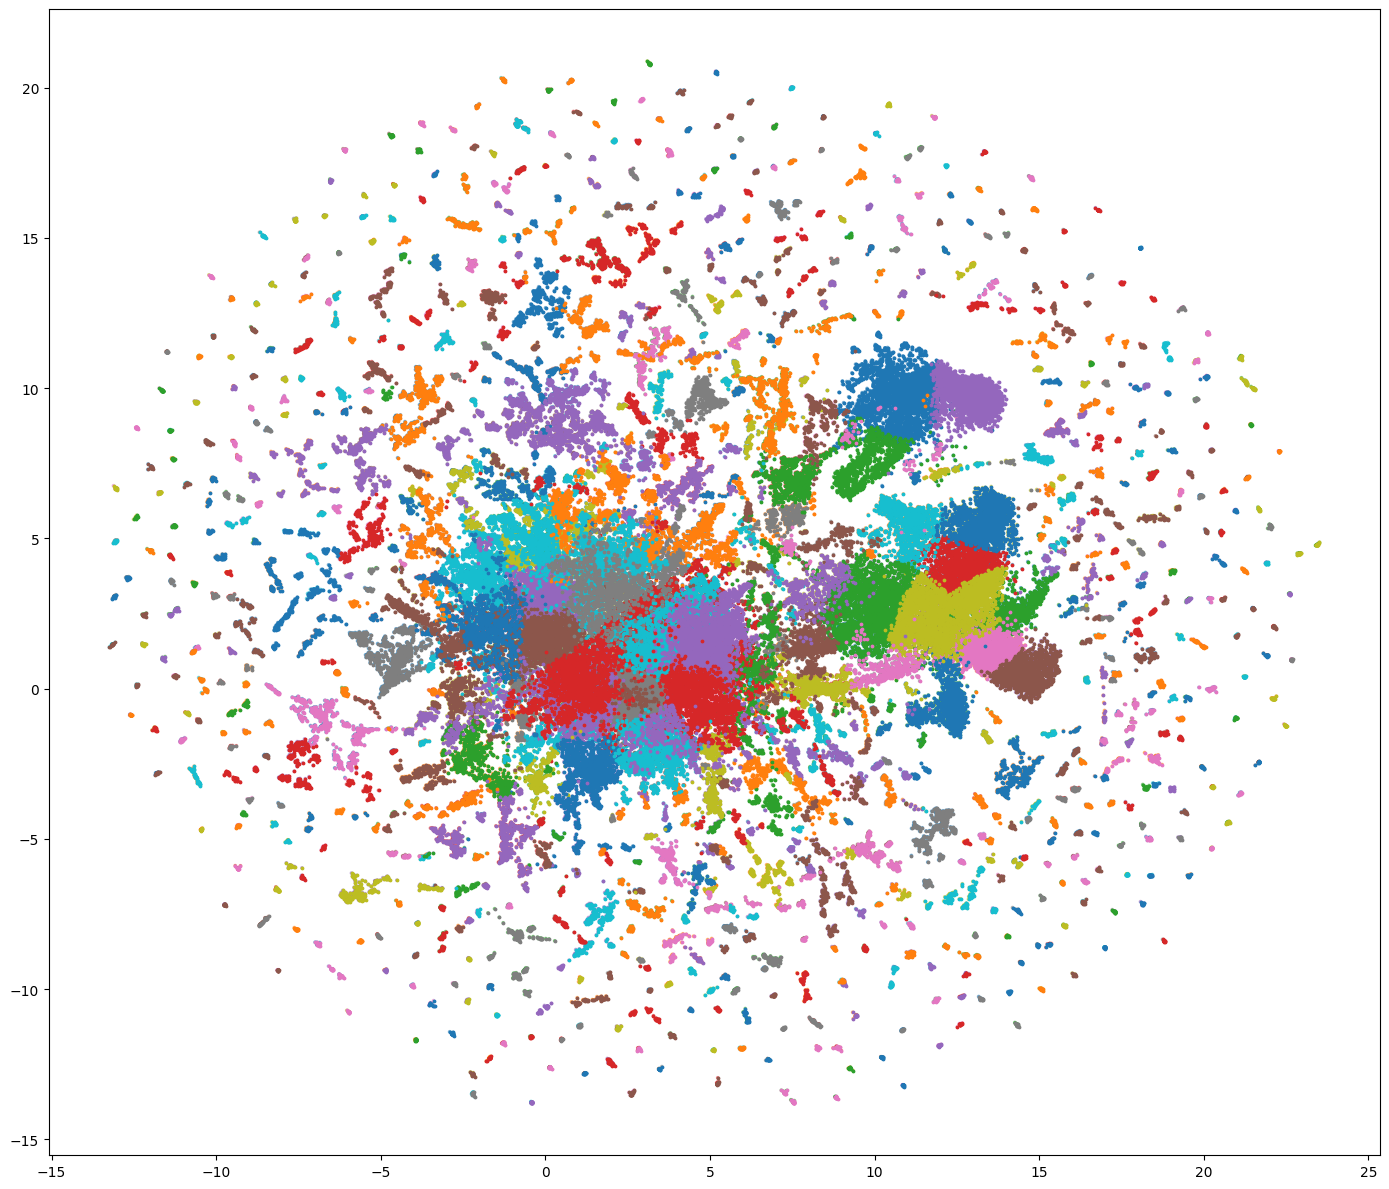

In [81]:
#create plot of k-means clustering
plt.figure(figsize=(14, 12))
plt.title('', fontsize=20)

plt.scatter(
    NB25_SS3_umap2[:, 0],
    NB25_SS3_umap2[:, 1],
    c=kmeans_labels,
    s=3,
    alpha=0.5,
    cmap='tab10')

#create legend patches instead of colorbar
unique_clusters = np.unique(kmeans_labels)
for cluster_id in unique_clusters:
    mask = kmeans_labels == cluster_id
    plt.scatter(
        NB25_SS3_umap2[mask, 0],
        NB25_SS3_umap2[mask, 1],
        s=3)
    
plt.tight_layout()
plt.show()

In [ ]:
# full site labels
sites_all = nepalbirds2021_sample3_even["site"]

# set colour coding (glasbey, 200 distinct colors)
colors = cc.glasbey[:200]

# assign each site a color
site_ids = np.unique(sites_all)
site_to_color = {sid: colors[i % len(colors)] for i, sid in enumerate(site_ids)}
site_colors = [site_to_color[sid] for sid in sites_all]

# plot
plt.figure(figsize=(14, 12))
plt.title('Sites shown on the 2D UMAP feature set', fontsize=20)
plt.xlabel("UMAP 1", fontsize=24)
plt.ylabel("UMAP 2", fontsize=24)

plt.scatter(
    NB25_SS3_umap2[:, 0],
    NB25_SS3_umap2[:, 1],
    c=site_colors,
    s=3,
    alpha=0.5
)

# optional legend (limit to first 20 for readability)
# legend_patches = [
#     mpatches.Patch(color=site_to_color[sid], label=f'Site: {sid}')
#     for sid in site_ids[:20]
# ]
# plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1),
#            loc='upper left', fontsize=12, ncol=2, frameon=False)

plt.tight_layout()
plt.savefig("umap32_kmeans_sites.png", dpi=600, bbox_inches='tight')
plt.show()

In [82]:
import pandas as pd
from IPython.display import display, HTML

# build cluster-site DataFrame
df_cluster_site_kmeans = pd.DataFrame({
    "cluster": kmeans_labels,
    "site": nepalbirds2021_sample3_even["site"]
})

# count site occurrences per cluster
cluster_site_counts_kmeans = df_cluster_site_kmeans.groupby(["cluster", "site"]).size().unstack(fill_value=0)

# count total count per cluster
cluster_counts_kmeans = cluster_site_counts_kmeans.sum(axis=1)

# convert counts to %
cluster_site_percent_kmeans = cluster_site_counts_kmeans.div(cluster_counts_kmeans, axis=0) * 100
cluster_site_percent_kmeans = cluster_site_percent_kmeans.round(1).sort_index(axis=1)

# add count column
cluster_site_percent_kmeans["count"] = cluster_counts_kmeans

# identify dominant site and its percentage
site_percent_only = cluster_site_percent_kmeans.drop(columns="count")
dominant_site = site_percent_only.idxmax(axis=1)
dominant_percent = site_percent_only.max(axis=1)

# build summary table
dominant_summary_kmeans = pd.DataFrame({
    "Dominant Site": dominant_site,
    "Percentage": dominant_percent.round(1),
    "Count": cluster_site_percent_kmeans["count"]})

# add label to combine later with other test cases
dominant_summary_case3 = dominant_summary_kmeans.copy()

# display scrollable summary table
scrollable_html = dominant_summary_kmeans.style.set_table_attributes(
    'style="display:inline-block;overflow-x:auto;max-width:1000px;"'
).set_caption("Highest percentage contribution of a site per k-means cluster")

display(HTML(scrollable_html.to_html()))

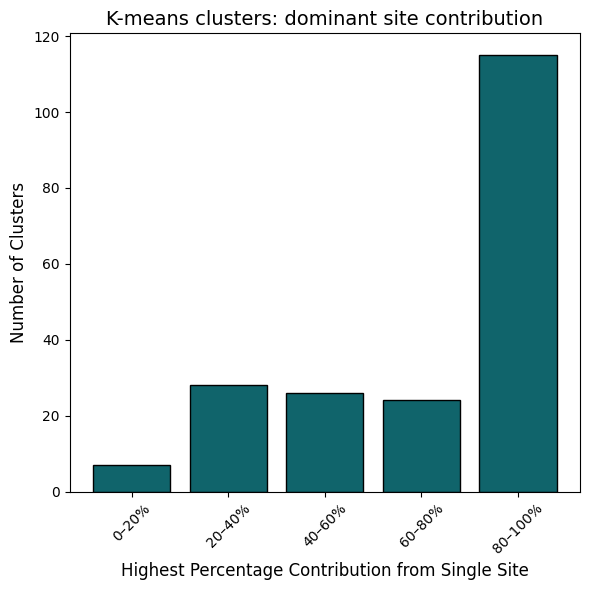

In [83]:
# take percentage column from k-means summary
dominant_percentages_kmeans = dominant_summary_kmeans["Percentage"]

# set bins and structure of histo
bins = range(0, 120, 20)  # 0 to 100 in steps of 20
bin_labels = [f"{i}–{i+20}%" for i in bins[:-1]]
hist = pd.cut(dominant_percentages_kmeans, bins=bins, labels=bin_labels, include_lowest=True)
bin_counts = hist.value_counts().sort_index()

# plot histo
plt.figure(figsize=(6, 6))
plt.bar(bin_counts.index, bin_counts.values, color="#10646b", edgecolor="black")
plt.xticks(rotation=45)
plt.xlabel("Highest Percentage Contribution from Single Site", fontsize=12)
plt.ylabel("Number of Clusters", fontsize=12)
plt.title("K-means clusters: dominant site contribution", fontsize=14)
plt.tight_layout()
plt.show()

## **5d - Compare across the three test cases how much they are dominated by one site:

In [1]:

# define bins and labels
bins = range(0, 120, 20)
bin_labels = [f"{i}–{i+20}%" for i in bins[:-1]]
## normalise bins to percentages
df_bins_pct = df_bins.div(df_bins.sum(axis=0), axis=1) * 100

# build bin counts for each of the three
def get_bin_counts(dominant_summary, bins, bin_labels):
    hist = pd.cut(dominant_summary["Percentage"], bins=bins, labels=bin_labels, include_lowest=True)
    return hist.value_counts().reindex(bin_labels, fill_value=0)

bin_counts_case1 = get_bin_counts(dominant_summary_case1, bins, bin_labels)
bin_counts_case2 = get_bin_counts(dominant_summary_case2, bins, bin_labels)
bin_counts_case3 = get_bin_counts(dominant_summary_case3, bins, bin_labels)

print("Case 1 bin counts:\n", bin_counts_case1, "\n")
print("Case 2 bin counts:\n", bin_counts_case2, "\n")
print("Case 3 bin counts:\n", bin_counts_case3, "\n")

# combine into single df
df_bins = pd.DataFrame({
    "Case 1": bin_counts_case1,
    "Case 2": bin_counts_case2,
    "Case 3": bin_counts_case3
})

# plot together three 
ax = df_bins_pct.plot(
    kind="bar",
    figsize=(8, 6),
    width=0.8,
    edgecolor="black",
    color=["#a6cee3", "#b2df8a", "#fb9a99"]
)

plt.xticks(rotation=45)
plt.xlabel("Highest Percentage Contribution from Single Site", fontsize=16)
plt.ylabel("Percentage of Clusters", fontsize=16)
plt.title("Comparison of Case Studies (Distribution of % Contributions of Single Site)", fontsize=18)
plt.legend(title="Case Study")
plt.tight_layout()
plt.savefig("3xmodels_site_to_cluster_contributions_pct.png", dpi=600, bbox_inches='tight')
plt.show()

NameError: name 'df_bins' is not defined